In [55]:
import random

import pandas as pd
import numpy as np
import itertools

import os
import json

import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score


warnings.filterwarnings('ignore')  # to suppress some matplotlib deprecation warnings

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

import numpy as np
import cv2
import json
from keras.applications.mobilenet import preprocess_input
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


# Any results you write to the current directory are saved as output.

input_path = "/Users/blue/Machine Learning"
train_simplified_path = input_path + "/train_simplified_small_set/"

train_simplified = os.listdir(train_simplified_path)
number_of_processes = os.cpu_count()
print("Number of processes:", number_of_processes)
BASE_SIZE = 256



Number of processes: 12


Util functions which are used to convert sketch into image of size*size dimention.

In [56]:
def image_generator_xd(dataframe, size, lw=6, time_color=True, ):
    dataframe['drawing'] = dataframe['drawing'].apply(json.loads)
    x = np.zeros((len(dataframe), size * size))
    for i, raw_strokes in enumerate(dataframe.drawing.values):
        x[i, :] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x, dataframe['word'].values


def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size)).reshape(-1)
    else:
        return img.reshape(-1)
    
    
def get_lambda(value):
    return lambda x: value

Function to prepare the test and training sets.

In [57]:
def read_file(file_name, label, value, rows=100):
    data = pd.read_csv(file_name, index_col='key_id', nrows=rows)
    data['word'] = data['word'].replace(label, value, regex=True)
    return data


# print(train_simplified)
def get_small_sample(dir_listing, sample_size=5, rows=100, random_sample=False):
    sample_files = None
    if random_sample:
        sample_files = random.sample(dir_listing, sample_size)
    else:
        sample_files = dir_listing[:sample_size]

    print("Samples in Account :", sample_files)
    mapping = dict()
    reverse_mapping = dict()

    data_set = []
    for i, sample in enumerate(sample_files):
        ex_name_raw = sample.split('.')[0]
        ex_name = ex_name_raw.replace(' ', '_')
        mapping[ex_name] = i
        reverse_mapping[i] = ex_name
        data_set.append(read_file(train_simplified_path + sample, ex_name_raw, i, rows))
    return data_set, mapping, reverse_mapping


def split_data(list_data_frames, ts= 0.1):
    training_frames = []
    testing_frames = []
    for df in list_data_frames:
        train_df, test_df = train_test_split(df, test_size=ts, shuffle=False)
        training_frames.append(train_df)
        testing_frames.append(test_df)
    return pd.concat(training_frames), pd.concat(testing_frames)



Prepare the test and training data.

In [58]:
no_of_classes = 20
no_of_rows = 5000

small_data_set, y_mapping, rev_y_mapping = get_small_sample(train_simplified, sample_size=no_of_classes,rows=no_of_rows)
train_set, test_set = split_data(small_data_set, ts = 0.1)

name_to_number = lambda x: y_mapping[x]
number_to_name = lambda x: rev_y_mapping[x]

x_train, y_train = image_generator_xd(train_set, 32)
x_test, y_test = image_generator_xd(test_set, 32)
print("Data prepared")

label_dict = {0:'guitar.csv', 1:'toilet.csv', 2:'banana.csv', 3:'bicycle.csv',4:'birthday cake.csv', 5:'jail.csv', 
              6:'The Eiffel Tower.csv', 7:'camera.csv', 8:'airplane.csv', 9:'bird.csv', 10:'cow.csv', 11:'windmill.csv',
              12:'cell phone.csv', 13:'umbrella.csv', 14:'butterfly.csv', 15:'fireplace.csv', 16:'snowflake.csv',
              17:'piano.csv', 18:'mushroom.csv', 19:'sailboat.csv'}


Samples in Account : ['guitar.csv', 'toilet.csv', 'banana.csv', 'bicycle.csv', 'birthday cake.csv', 'jail.csv', 'The Eiffel Tower.csv', 'camera.csv', 'airplane.csv', 'bird.csv', 'cow.csv', 'windmill.csv', 'cell phone.csv', 'umbrella.csv', 'butterfly.csv', 'fireplace.csv', 'snowflake.csv', 'piano.csv', 'mushroom.csv', 'sailboat.csv']
Data prepared


The Random forest Classifier:

In [59]:
print("---Starting Random Forest----")
# Base RFC model
rfc = RandomForestClassifier(random_state=1)
rfc.fit(x_train, y_train)
print(rfc)
y_pred_rfc = rfc.predict(x_test)
acc_rfc = accuracy_score(y_test, y_pred_rfc)
print('Random forest accuracy: ', acc_rfc)

---Starting Random Forest----
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
Random forest accuracy:  0.5359


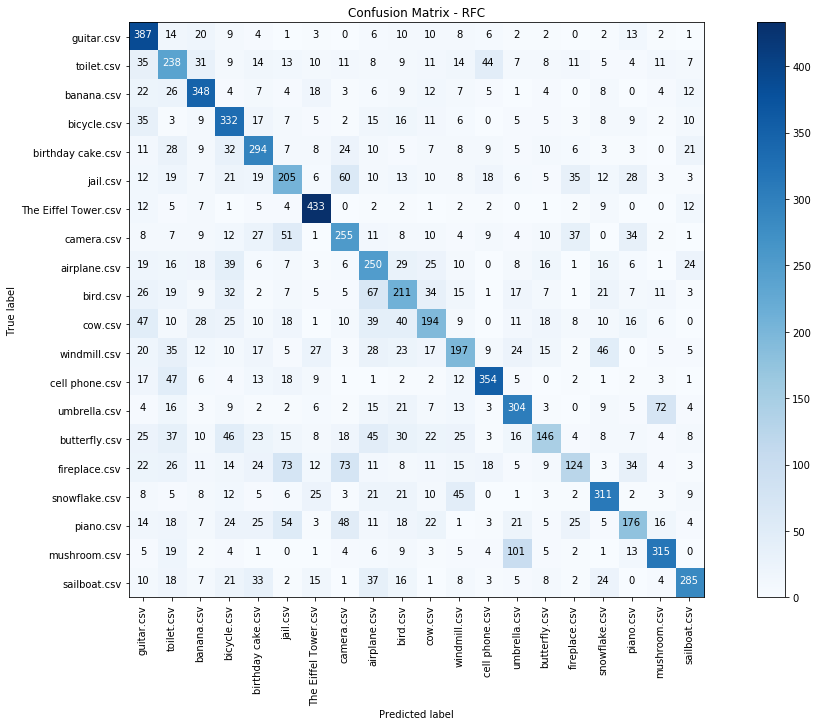

In [60]:
# Compute confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_rfc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(15,10))
fig = plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
_ =plt.title('Confusion Matrix - RFC')
_ = plt.colorbar()
_ = tick_marks = np.arange(len(label_dict))
_ = plt.xticks(tick_marks, label_dict.values(), rotation=90)
_ = plt.yticks(tick_marks, label_dict.values())
_ = plt.tight_layout()
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')
thresh = cf_matrix.max() / 2.
for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
    plt.text(j, i, cf_matrix[i, j], horizontalalignment="center",
                color="white" if cf_matrix[i, j] > thresh else "black")

Performing grid search to tune the paramerters:

In [61]:
###############Grid search#######
# Tuning number of estimators in the ensemble method
parameters = {'n_estimators': np.arange(70,150,10)}
rfc = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc_gs = GridSearchCV(rfc, parameters, n_jobs=-1)
rfc_gs.fit(x_train, y_train)

results_rfc_gs = pd.DataFrame(rfc_gs.cv_results_)
results_rfc_gs.sort_values('mean_test_score', ascending = False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,116.299869,5.872046,2.981256,0.664267,140,{'n_estimators': 140},0.652700,0.655433,0.651167,0.653100,0.001765,1,0.999983,1.0,0.999983,0.999989,0.000008
6,138.974668,3.706816,4.848940,0.382298,130,{'n_estimators': 130},0.650000,0.652967,0.649600,0.650856,0.001502,2,0.999983,1.0,0.999983,0.999989,0.000008
5,148.226924,2.164829,6.990828,0.281114,120,{'n_estimators': 120},0.649500,0.651233,0.647767,0.649500,0.001415,3,0.999983,1.0,0.999983,0.999989,0.000008
4,148.771677,1.204547,8.434462,0.470050,110,{'n_estimators': 110},0.648233,0.650100,0.647167,0.648500,0.001212,4,0.999983,1.0,0.999983,0.999989,0.000008
3,130.908520,0.673482,8.385248,0.336022,100,{'n_estimators': 100},0.645700,0.647333,0.643533,0.645522,0.001556,5,0.999983,1.0,0.999983,0.999989,0.000008
2,111.793008,3.079630,8.062554,0.276412,90,{'n_estimators': 90},0.642900,0.644867,0.642333,0.643367,0.001086,6,0.999983,1.0,0.999983,0.999989,0.000008
1,82.310531,5.418167,6.763688,0.036290,80,{'n_estimators': 80},0.639467,0.643067,0.639400,0.640644,0.001713,7,0.999983,1.0,0.999983,0.999989,0.000008
0,47.060957,5.993230,4.279980,0.876211,70,{'n_estimators': 70},0.636700,0.637033,0.635767,0.636500,0.000536,8,0.999983,1.0,0.999983,0.999989,0.000008


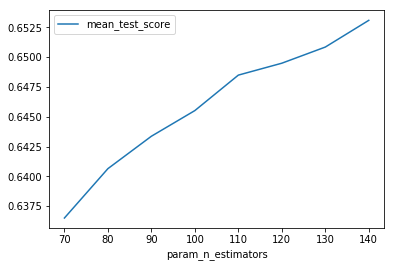

In [62]:
# Plot results of grid search
results_rfc_gs.plot('param_n_estimators','mean_test_score')

In [63]:
# Tuning max features
parameters = {'max_features':['log2','sqrt',.1,.3,.5]}

rfc = RandomForestClassifier(n_estimators= 140, random_state=1, n_jobs=-1)
rfc_gs = GridSearchCV(rfc, parameters, n_jobs=-1)
rfc_gs.fit(x_train, y_train)

results_rfc_gs = pd.DataFrame(rfc_gs.cv_results_)
results_rfc_gs.sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,159.491118,5.403025,8.521745,0.806269,sqrt,{'max_features': 'sqrt'},0.652700,0.655433,0.651167,0.653100,0.001765,1,0.999983,1.0,0.999983,0.999989,0.000008
0,35.688689,5.306303,7.004541,1.585494,log2,{'max_features': 'log2'},0.652133,0.650033,0.650367,0.650844,0.000921,2,0.999983,1.0,0.999983,0.999989,0.000008
2,405.700306,1.556549,7.691042,0.618422,0.1,{'max_features': 0.1},0.645500,0.649067,0.647767,0.647444,0.001474,3,0.999983,1.0,0.999983,0.999989,0.000008
3,852.857426,4.707590,5.451057,1.027442,0.3,{'max_features': 0.3},0.636133,0.638700,0.633500,0.636111,0.002123,4,0.999983,1.0,0.999983,0.999989,0.000008
4,1053.269540,7.222894,2.336710,0.798163,0.5,{'max_features': 0.5},0.625567,0.630133,0.626933,0.627544,0.001914,5,0.999983,1.0,0.999983,0.999989,0.000008


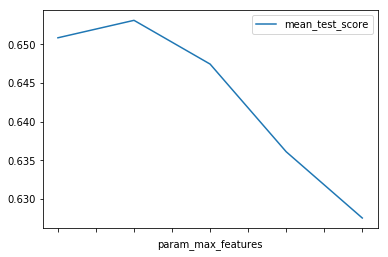

In [64]:
# Plot results of grid search
results_rfc_gs.plot('param_max_features','mean_test_score')

In [65]:
# Modeling RFC with best hyper-parameters
rfc = RandomForestClassifier(n_estimators=140, max_features='sqrt', random_state=1, n_jobs=-1)
rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_test)
acc_rfc = accuracy_score(y_test, y_pred_rfc)
print ('Random forest accuracy: ',acc_rfc)

Random forest accuracy:  0.677


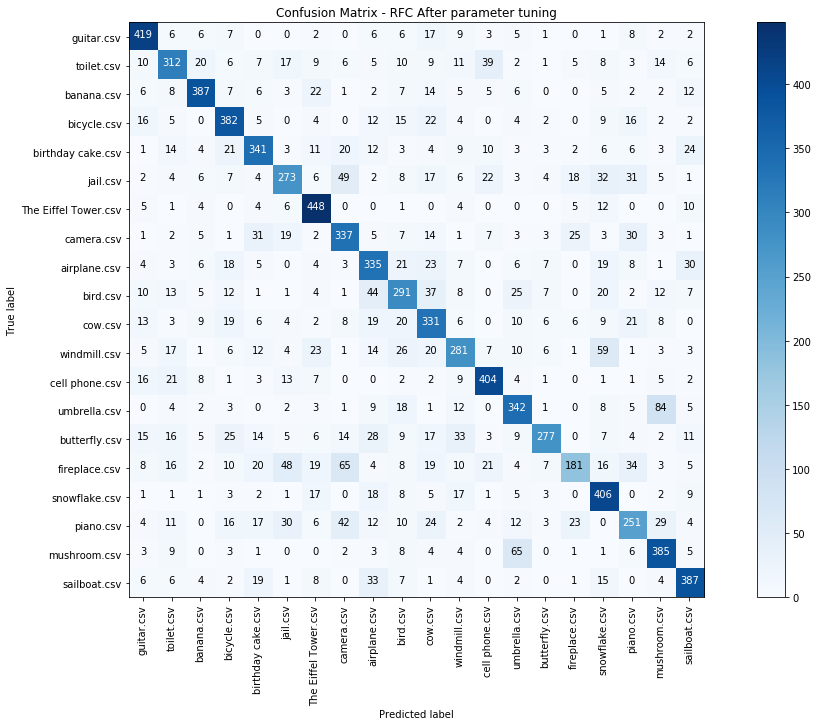

In [66]:
# Compute confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_rfc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(15,10))
fig = plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
_ =plt.title('Confusion Matrix - RFC After parameter tuning')
_ = plt.colorbar()
_ = tick_marks = np.arange(len(label_dict))
_ = plt.xticks(tick_marks, label_dict.values(), rotation=90)
_ = plt.yticks(tick_marks, label_dict.values())
_ = plt.tight_layout()
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')
thresh = cf_matrix.max() / 2.
for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
    plt.text(j, i, cf_matrix[i, j], horizontalalignment="center",
                color="white" if cf_matrix[i, j] > thresh else "black")

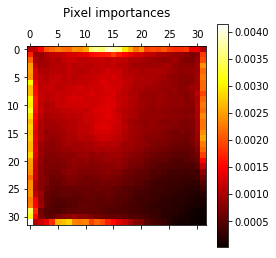

In [67]:
importances = rfc.feature_importances_
importances = importances.reshape((32,32))
fig = plt.matshow(importances, cmap=plt.cm.hot)
plt.title('Pixel importances\n')
plt.colorbar()

In [68]:
print("SVM with linear kernal")
lsvc = LinearSVC(random_state=1)
lsvc.fit(x_train, y_train)
print(lsvc)
y_pred_lsvc = lsvc.predict(x_test)
acc_lsvc = accuracy_score(y_test, y_pred_lsvc)
print('Linear SVC accuracy: ', acc_lsvc)

SVM with linear kernal
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0)
Linear SVC accuracy:  0.4857


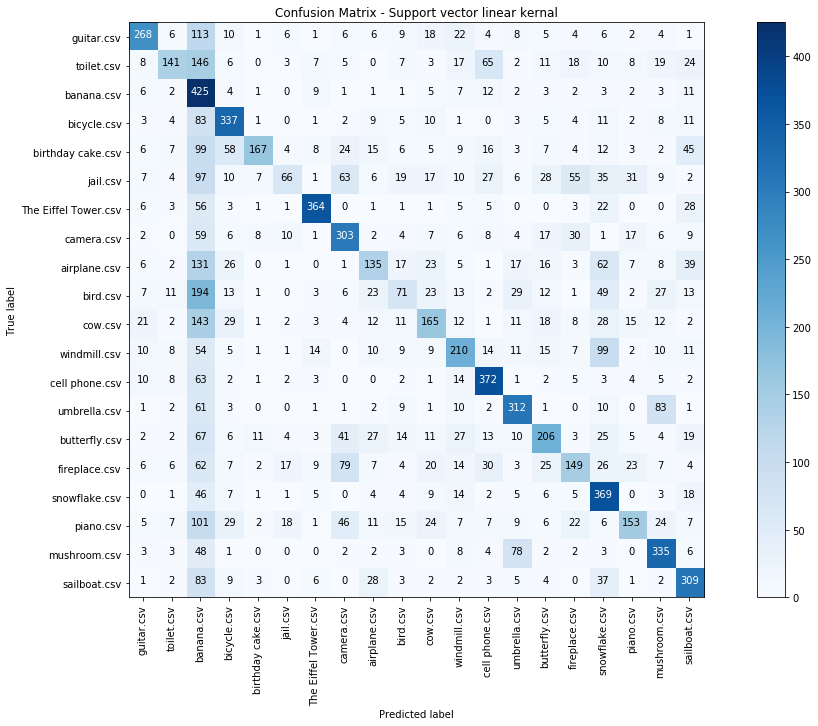

In [69]:
# Compute confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lsvc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(15,10))
fig = plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
_ =plt.title('Confusion Matrix - Support vector linear kernal')
_ = plt.colorbar()
_ = tick_marks = np.arange(len(label_dict))
_ = plt.xticks(tick_marks, label_dict.values(), rotation=90)
_ = plt.yticks(tick_marks, label_dict.values())
_ = plt.tight_layout()
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')
thresh = cf_matrix.max() / 2.
for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
    plt.text(j, i, cf_matrix[i, j], horizontalalignment="center",
                color="white" if cf_matrix[i, j] > thresh else "black")

In [70]:
print("SVM with RBF Kernal")
svc = SVC(kernel='rbf', random_state=1)
svc.fit(x_train, y_train)
print(svc)
y_pred_svc_rbf = svc.predict(x_test)
acc_svc_rbf = accuracy_score(y_test, y_pred_svc_rbf)
print('Gaussian Radial Basis Function SVC Accuracy: ', acc_svc_rbf)

SVM with RBF Kernal
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)
Gaussian Radial Basis Function SVC Accuracy:  0.7255


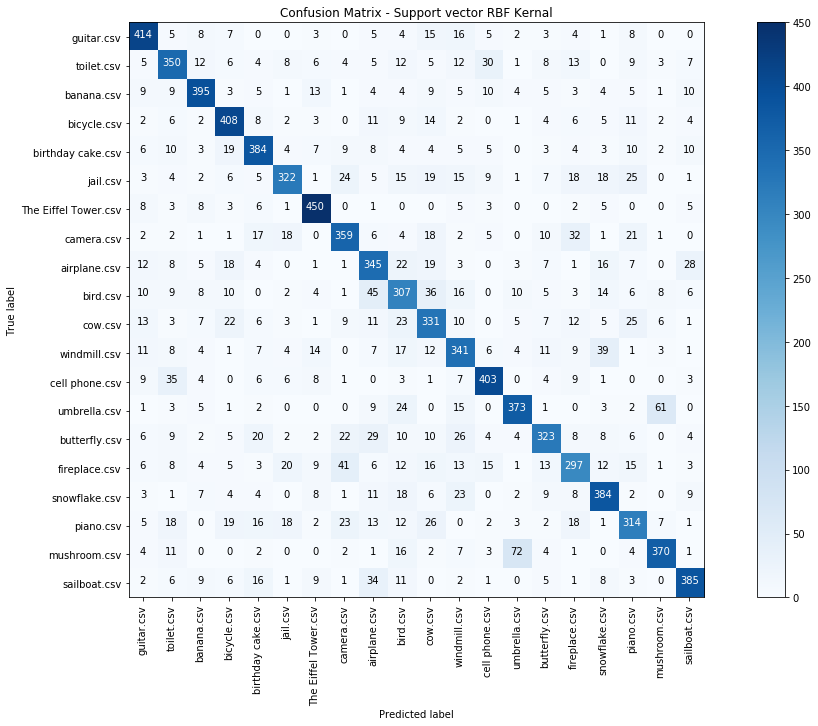

In [71]:
# Compute confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_svc_rbf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(15,10))
fig = plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
_ =plt.title('Confusion Matrix - Support vector RBF Kernal')
_ = plt.colorbar()
_ = tick_marks = np.arange(len(label_dict))
_ = plt.xticks(tick_marks, label_dict.values(), rotation=90)
_ = plt.yticks(tick_marks, label_dict.values())
_ = plt.tight_layout()
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')
thresh = cf_matrix.max() / 2.
for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
    plt.text(j, i, cf_matrix[i, j], horizontalalignment="center",
                color="white" if cf_matrix[i, j] > thresh else "black")